In [88]:
"""
Personalized Recipe Recommendation System Using ML
CS:584 Machine Learning Project

Team Members:
- Jayawardhan Meesala (A20541523)
- Saran Mannam (A20553408)
- Morareddy Rahul Reddy (A20537404)
- Venkata Uday Boggarapu (A20539570)
- Sri Krishna Dhanush Bondada (A20539380)

Instructor: Shouvik Roy
Date: 2/9/2025
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import json
import pickle
import warnings
import ast
from collections import defaultdict
import re
from tqdm.auto import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Project structure constants
DATA_DIR = "data/"
MODELS_DIR = "models/"
RESULTS_DIR = "results/"

# Create necessary directories
for directory in [DATA_DIR, MODELS_DIR, RESULTS_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Data file paths
FOOD_CSV = os.path.join(DATA_DIR, "Food.com/food.csv")
FOOD_CATEGORY_CSV = os.path.join(DATA_DIR, "Food.com/food_category.csv")
FOOD_NUTRIENT_CSV = os.path.join(DATA_DIR, "Food.com/food_nutrient.csv")
NUTRIENT_CSV = os.path.join(DATA_DIR, "Food.com/nutrient.csv")
RECIPES_CSV = os.path.join(DATA_DIR, "PP_recipes.csv/PP_recipes.csv")

# =============================================================================
# Data Loading and Processing
# =============================================================================

class DataLoader:
    """Loads and processes data from Food.com and USDA datasets"""
    
    def __init__(self):
        self.food_df = None
        self.food_category_df = None
        self.food_nutrient_df = None
        self.nutrient_df = None
        self.recipes_df = None
        self.interactions_df = None
    
    def load_usda_data(self):
        """Load USDA FoodData Central datasets"""
        print("Loading USDA FoodData Central data...")
        
        try:
            # Load food data
            self.food_df = pd.read_csv(FOOD_CSV)
            print(f"Loaded {len(self.food_df)} food items")
            
            # Load food category data
            self.food_category_df = pd.read_csv(FOOD_CATEGORY_CSV)
            print(f"Loaded {len(self.food_category_df)} food categories")
            
            # Load nutrient data
            self.nutrient_df = pd.read_csv(NUTRIENT_CSV)
            print(f"Loaded {len(self.nutrient_df)} nutrients")
            
            # Load food-nutrient data with chunking due to potential large size
            chunks = []
            chunk_size = 100000
            for chunk in pd.read_csv(FOOD_NUTRIENT_CSV, chunksize=chunk_size):
                chunks.append(chunk)
            self.food_nutrient_df = pd.concat(chunks)
            print(f"Loaded {len(self.food_nutrient_df)} food-nutrient relationships")
            
            return {
                'food': self.food_df,
                'food_category': self.food_category_df,
                'nutrient': self.nutrient_df,
                'food_nutrient': self.food_nutrient_df
            }
        except Exception as e:
            print(f"Error loading USDA data: {e}")
            print("Creating synthetic USDA data instead...")
            
            # Create synthetic food data
            self.food_df = pd.DataFrame({
                'fdc_id': range(1, 1001),
                'data_type': 'synthetic',
                'description': [f'food_item_{i}' for i in range(1, 1001)],
                'food_category_id': np.random.randint(1, 29, 1000),
                'publication_date': pd.Timestamp('2023-01-01')
            })
            
            # Create synthetic food category data
            self.food_category_df = pd.DataFrame({
                'id': range(1, 29),
                'code': range(101, 129),
                'description': [f'category_{i}' for i in range(1, 29)]
            })
            
            # Create synthetic nutrient data
            nutrients = ['Energy', 'Protein', 'Fat', 'Carbohydrates', 'Fiber', 'Sugar', 'Sodium']
            units = ['kcal', 'g', 'g', 'g', 'g', 'g', 'mg']
            
            self.nutrient_df = pd.DataFrame({
                'id': range(1, len(nutrients) + 1),
                'name': nutrients,
                'unit_name': units,
                'nutrient_nbr': range(1, len(nutrients) + 1),
                'rank': range(1, len(nutrients) + 1)
            })
            
            # Create synthetic food-nutrient data
            nutrient_data = []
            for food_id in range(1, 1001):
                for nutrient_id in range(1, len(nutrients) + 1):
                    if np.random.random() > 0.3:  # 70% chance of having each nutrient
                        nutrient_data.append({
                            'id': len(nutrient_data) + 1,
                            'fdc_id': food_id,
                            'nutrient_id': nutrient_id,
                            'amount': np.random.random() * 100,
                        })
            
            self.food_nutrient_df = pd.DataFrame(nutrient_data)
            
            print("Created synthetic USDA data")
            return {
                'food': self.food_df,
                'food_category': self.food_category_df,
                'nutrient': self.nutrient_df,
                'food_nutrient': self.food_nutrient_df
            }
    
    def load_recipe_data(self):
        """Load Food.com recipe data"""
        print("Loading Food.com recipe data...")
        
        try:
            # Load preprocessed recipe data
            self.recipes_df = pd.read_csv(RECIPES_CSV)
            print(f"Loaded {len(self.recipes_df)} recipes")
            
            # Process tokenized fields
            self._process_recipe_tokens()
            
            return self.recipes_df
        except Exception as e:
            print(f"Error loading recipe data: {e}")
            print("Creating synthetic recipe data...")
            
            # Create synthetic recipe data
            n_recipes = 1000
            recipes = []
            
            for i in range(1, n_recipes + 1):
                recipes.append({
                    'id': i,
                    'i': i,
                    'name_tokens': str(['recipe', str(i)]),
                    'ingredient_tokens': str([['ingredient', str(j)] for j in range(1, np.random.randint(3, 10))]),
                    'steps_tokens': str([['step', str(j)] for j in range(1, np.random.randint(3, 8))]),
                    'techniques': str(['technique' + str(j) for j in range(1, np.random.randint(1, 5))]),
                    'calorie_level': np.random.choice(['low', 'medium', 'high']),
                    'ingredient_ids': str([j for j in range(1, np.random.randint(3, 10))])
                })
            
            self.recipes_df = pd.DataFrame(recipes)
            
            # Process tokenized fields
            self._process_recipe_tokens()
            
            print(f"Created {len(self.recipes_df)} synthetic recipes")
            return self.recipes_df
    
    def _process_recipe_tokens(self):
     """Process tokenized fields in recipe data"""
     print("Processing recipe token fields...")
    
     try:
        # Try to extract actual recipe names from name_tokens if available
        if 'name_tokens' in self.recipes_df.columns:
            self.recipes_df['recipe_name'] = self.recipes_df['name_tokens'].apply(
                lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else f"Recipe {x}")
        else:
            self.recipes_df['recipe_name'] = "Recipe " + self.recipes_df['id'].astype(str)
        
        # Try to extract ingredients from ingredient_tokens if available
        if 'ingredient_tokens' in self.recipes_df.columns:
            self.recipes_df['ingredients'] = self.recipes_df['ingredient_tokens'].apply(
                lambda x: ', '.join([' '.join(ing) for ing in ast.literal_eval(x)]) 
                if isinstance(x, str) else f"Ingredients for recipe {x}")
        else:
            self.recipes_df['ingredients'] = "Ingredients for recipe " + self.recipes_df['id'].astype(str)
        
        # Extract instructions if available
        if 'steps_tokens' in self.recipes_df.columns:
            self.recipes_df['instructions'] = self.recipes_df['steps_tokens'].apply(
                lambda x: '. '.join([' '.join(step) for step in ast.literal_eval(x)]) 
                if isinstance(x, str) else f"Instructions for recipe {x}")
        else:
            self.recipes_df['instructions'] = "Instructions for recipe " + self.recipes_df['id'].astype(str)
            
     except Exception as e:
        print(f"Error processing recipe tokens: {e}")
        # Fall back to placeholder values
        self.recipes_df['recipe_name'] = "Recipe " + self.recipes_df['id'].astype(str)
        self.recipes_df['ingredients'] = "Ingredients for recipe " + self.recipes_df['id'].astype(str)
        self.recipes_df['instructions'] = "Instructions for recipe " + self.recipes_df['id'].astype(str)
    
    print("Recipe token processing complete")
    
    def generate_user_interactions(self, n_users=500, n_interactions=10000):
        """Generate synthetic user-recipe interactions"""
        print("Generating synthetic user interactions...")
        
        # Set random seed for reproducibility
        np.random.seed(42)
        
        # Get recipe IDs
        recipe_ids = self.recipes_df['id'].unique()
        
        # Generate random interactions
        user_ids = np.arange(1, n_users + 1)
        interactions = []
        
        for _ in range(n_interactions):
            user_id = np.random.choice(user_ids)
            recipe_id = np.random.choice(recipe_ids)
            rating = np.random.randint(1, 6)  # Ratings from 1-5
            timestamp = pd.Timestamp('2023-01-01') + pd.Timedelta(days=np.random.randint(0, 365))
            
            interactions.append({
                'user_id': user_id,
                'recipe_id': recipe_id,
                'rating': rating,
                'timestamp': timestamp
            })
        
        self.interactions_df = pd.DataFrame(interactions)
        
        # Save the interactions
        interactions_path = os.path.join(DATA_DIR, "synthetic_interactions.csv")
        self.interactions_df.to_csv(interactions_path, index=False)
        
        print(f"Generated {len(self.interactions_df)} synthetic user interactions")
        return self.interactions_df
    
    def enrich_recipes_with_nutrition(self):
        """Add nutritional information to recipes"""
        print("Adding nutritional information to recipes...")
        
        # Add synthetic nutritional values
        self.recipes_df['calories'] = np.random.randint(100, 800, size=len(self.recipes_df))
        self.recipes_df['protein'] = np.random.uniform(5, 30, size=len(self.recipes_df))
        self.recipes_df['fat'] = np.random.uniform(5, 30, size=len(self.recipes_df))
        self.recipes_df['carbs'] = np.random.uniform(20, 100, size=len(self.recipes_df))
        self.recipes_df['fiber'] = np.random.uniform(1, 10, size=len(self.recipes_df))
        self.recipes_df['sugar'] = np.random.uniform(1, 20, size=len(self.recipes_df))
        self.recipes_df['sodium'] = np.random.uniform(100, 1000, size=len(self.recipes_df))
        
        # Save the enriched recipes
        enriched_path = os.path.join(DATA_DIR, "enriched_recipes.csv")
        self.recipes_df.to_csv(enriched_path, index=False)
        
        print("Added nutritional information to recipes")
        return self.recipes_df
    
    def load_all_data(self):
        """Load and prepare all datasets"""
        # Load USDA data
        usda_data = self.load_usda_data()
        
        # Load recipe data
        recipe_data = self.load_recipe_data()
        
        # Generate synthetic interactions if they don't exist
        interactions_path = os.path.join(DATA_DIR, "synthetic_interactions.csv")
        if os.path.exists(interactions_path):
            try:
                self.interactions_df = pd.read_csv(interactions_path)
                print(f"Loaded {len(self.interactions_df)} user interactions")
            except:
                self.generate_user_interactions()
        else:
            self.generate_user_interactions()
        
        # Enrich recipes with nutritional information
        enriched_recipes = self.enrich_recipes_with_nutrition()
        
        return {
            'recipes': enriched_recipes,
            'interactions': self.interactions_df,
            'usda': usda_data
        }


class DataPreprocessor:
    """Handles data preprocessing and feature engineering"""
    
    def __init__(self):
        self.recipes_df = None
        self.interactions_df = None
        self.user_item_matrix = None
        self.recipe_features = None
        self.user_features = None
    
    def load_data(self):
        """Load preprocessed data"""
        enriched_path = os.path.join(DATA_DIR, "enriched_recipes.csv")
        interactions_path = os.path.join(DATA_DIR, "synthetic_interactions.csv")
        
        try:
            self.recipes_df = pd.read_csv(enriched_path)
            self.interactions_df = pd.read_csv(interactions_path)
            print(f"Loaded {len(self.recipes_df)} recipes and {len(self.interactions_df)} interactions")
            return True
        except Exception as e:
            print(f"Error loading data: {e}")
            return False
    
    def clean_interactions(self):
        """Clean and filter user interactions"""
        print("Cleaning interaction data...")
        
        # Remove duplicates
        self.interactions_df = self.interactions_df.drop_duplicates(subset=['user_id', 'recipe_id'])
        
        # Filter users with few interactions
        user_counts = self.interactions_df['user_id'].value_counts()
        active_users = user_counts[user_counts >= 5].index
        self.interactions_df = self.interactions_df[self.interactions_df['user_id'].isin(active_users)]
        
        print(f"After cleaning: {len(self.interactions_df)} interactions from {len(active_users)} users")
        return self.interactions_df
    
    def create_train_test_splits(self, test_size=0.2):
        """Create training and testing splits"""
        print("Creating train/test splits...")
        
        try:
            # Split the data
            train_df, test_df = train_test_split(
                self.interactions_df,
                test_size=test_size,
                random_state=42
            )
            # Save the splits
            train_path = os.path.join(DATA_DIR, "train_interactions.csv")
            test_path = os.path.join(DATA_DIR, "test_interactions.csv")
            
            train_df.to_csv(train_path, index=False)
            test_df.to_csv(test_path, index=False)
            
            print(f"Training set: {len(train_df)}, Test set: {len(test_df)}")
            return train_df, test_df
        except Exception as e:
            print(f"Error creating splits: {e}")
            # Create dummy splits as fallback
            midpoint = int(len(self.interactions_df) * 0.8)
            train_df = self.interactions_df.iloc[:midpoint]
            test_df = self.interactions_df.iloc[midpoint:]
            
            train_path = os.path.join(DATA_DIR, "train_interactions.csv")
            test_path = os.path.join(DATA_DIR, "test_interactions.csv")
            
            train_df.to_csv(train_path, index=False)
            test_df.to_csv(test_path, index=False)
            
            return train_df, test_df
    
    def create_user_item_matrix(self, train_df):
        """Create the user-item matrix for collaborative filtering"""
        print("Creating user-item matrix...")
        
        try:
            # Create pivot table
            matrix = train_df.pivot_table(
                index='user_id',
                columns='recipe_id',
                values='rating',
                fill_value=0
            )
            
            # Create mappings
            user_to_idx = {user: i for i, user in enumerate(matrix.index)}
            recipe_to_idx = {recipe: i for i, recipe in enumerate(matrix.columns)}
            
            # Save mappings
            user_mapping = {
                'user_to_idx': user_to_idx,
                'idx_to_user': {i: user for user, i in user_to_idx.items()}
            }
            
            recipe_mapping = {
                'recipe_to_idx': recipe_to_idx,
                'idx_to_recipe': {i: recipe for recipe, i in recipe_to_idx.items()}
            }
            
            # Save to disk
            with open(os.path.join(DATA_DIR, "user_mapping.pkl"), 'wb') as f:
                pickle.dump(user_mapping, f)
                
            with open(os.path.join(DATA_DIR, "recipe_mapping.pkl"), 'wb') as f:
                pickle.dump(recipe_mapping, f)
            
            # Convert to sparse matrix
            self.user_item_matrix = csr_matrix(matrix.values)
            
            # Save sparse matrix
            with open(os.path.join(DATA_DIR, "user_item_matrix.pkl"), 'wb') as f:
                pickle.dump(self.user_item_matrix, f)
            
            print(f"Created user-item matrix with shape: {self.user_item_matrix.shape}")
            return self.user_item_matrix, user_mapping, recipe_mapping
        
        except Exception as e:
            print(f"Error creating user-item matrix: {e}")
            print("Creating simplified matrix...")
            
            # Create simplified matrix
            unique_users = train_df['user_id'].unique()
            unique_recipes = train_df['recipe_id'].unique()
            
            # Map IDs to indices
            user_to_idx = {user: i for i, user in enumerate(unique_users)}
            recipe_to_idx = {recipe: i for i, recipe in enumerate(unique_recipes)}
            
            # Create sparse matrix
            rows, cols, data = [], [], []
            
            for _, row in train_df.iterrows():
                user_idx = user_to_idx[row['user_id']]
                recipe_idx = recipe_to_idx[row['recipe_id']]
                rating = row['rating']
                
                rows.append(user_idx)
                cols.append(recipe_idx)
                data.append(rating)
            
            self.user_item_matrix = csr_matrix((data, (rows, cols)), 
                                             shape=(len(unique_users), len(unique_recipes)))
            
            # Create mappings
            user_mapping = {
                'user_to_idx': user_to_idx,
                'idx_to_user': {i: user for user, i in user_to_idx.items()}
            }
            
            recipe_mapping = {
                'recipe_to_idx': recipe_to_idx,
                'idx_to_recipe': {i: recipe for recipe, i in recipe_to_idx.items()}
            }
            
            # Save to disk
            with open(os.path.join(DATA_DIR, "user_mapping.pkl"), 'wb') as f:
                pickle.dump(user_mapping, f)
                
            with open(os.path.join(DATA_DIR, "recipe_mapping.pkl"), 'wb') as f:
                pickle.dump(recipe_mapping, f)
            
            # Save sparse matrix
            with open(os.path.join(DATA_DIR, "user_item_matrix.pkl"), 'wb') as f:
                pickle.dump(self.user_item_matrix, f)
            
            print(f"Created simplified matrix with shape: {self.user_item_matrix.shape}")
            return self.user_item_matrix, user_mapping, recipe_mapping
    
    def create_recipe_features(self):
        """Create recipe features for content-based filtering"""
        print("Creating recipe features...")
        
        try:
            # Extract features
            features = []
            
            for _, recipe in self.recipes_df.iterrows():
                feature = {
                    'recipe_id': recipe['id'],
                    'calories': recipe.get('calories', 0),
                    'protein': recipe.get('protein', 0),
                    'fat': recipe.get('fat', 0), 
                    'carbs': recipe.get('carbs', 0),
                    'fiber': recipe.get('fiber', 0),
                    'sugar': recipe.get('sugar', 0),
                    'sodium': recipe.get('sodium', 0)
                }
                
                # Add calorie level as a feature if available
                if 'calorie_level' in recipe:
                    if recipe['calorie_level'] == 'low':
                        feature['calorie_level_low'] = 1
                        feature['calorie_level_medium'] = 0
                        feature['calorie_level_high'] = 0
                    elif recipe['calorie_level'] == 'medium':
                        feature['calorie_level_low'] = 0
                        feature['calorie_level_medium'] = 1
                        feature['calorie_level_high'] = 0
                    elif recipe['calorie_level'] == 'high':
                        feature['calorie_level_low'] = 0
                        feature['calorie_level_medium'] = 0
                        feature['calorie_level_high'] = 1
                
                features.append(feature)
            
            # Create dataframe
            self.recipe_features = pd.DataFrame(features)
            
            # Fill missing values
            self.recipe_features = self.recipe_features.fillna(0)
            
            # Scale numerical features
            scaler = StandardScaler()
            num_cols = ['calories', 'protein', 'fat', 'carbs', 'fiber', 'sugar', 'sodium']
            num_cols = [col for col in num_cols if col in self.recipe_features.columns]
            
            if num_cols:
                self.recipe_features[num_cols] = scaler.fit_transform(self.recipe_features[num_cols])
            
            # Save the scaler
            with open(os.path.join(DATA_DIR, "recipe_scaler.pkl"), 'wb') as f:
                pickle.dump(scaler, f)
            
            # Save features
            self.recipe_features.to_csv(os.path.join(DATA_DIR, "recipe_features.csv"), index=False)
            
            print(f"Created features for {len(self.recipe_features)} recipes")
            return self.recipe_features
            
        except Exception as e:
            print(f"Error creating recipe features: {e}")
            print("Creating simplified features...")
            
            # Create simple features
            recipe_ids = self.recipes_df['id'].unique()
            simplified_features = []
            
            for recipe_id in recipe_ids:
                feature = {
                    'recipe_id': recipe_id,
                    'feature1': np.random.random(),
                    'feature2': np.random.random(),
                    'feature3': np.random.random(),
                }
                simplified_features.append(feature)
            
            self.recipe_features = pd.DataFrame(simplified_features)
            
            # Save features
            self.recipe_features.to_csv(os.path.join(DATA_DIR, "recipe_features.csv"), index=False)
            
            print(f"Created simplified features for {len(recipe_ids)} recipes")
            return self.recipe_features
    
    def create_user_profiles(self, train_df):
        """Create user profiles for content-based filtering"""
        print("Creating user profiles...")
        
        try:
            # Calculate average ratings per user
            user_stats = train_df.groupby('user_id').agg({
                'rating': ['mean', 'count', 'std']
            })
            
            user_stats.columns = ['avg_rating', 'rating_count', 'rating_std']
            user_stats = user_stats.reset_index()
            
            # Create user preferences based on recipe features
            if self.recipe_features is None:
                self.recipe_features = pd.read_csv(os.path.join(DATA_DIR, "recipe_features.csv"))
            
            # Set index for easier lookup
            recipe_features_indexed = self.recipe_features.set_index('recipe_id')
            
            # Create user profiles
            user_profiles = []
            
            for user_id in user_stats['user_id']:
                # Get user's ratings
                user_ratings = train_df[train_df['user_id'] == user_id]
                
                # Get feature columns (exclude recipe_id)
                feature_cols = recipe_features_indexed.columns
                
                # Initialize profile vector
                profile = np.zeros(len(feature_cols))
                profile_dict = {'user_id': user_id}
                
                # Get weighted average of recipe features
                total_weight = 0
                
                for _, row in user_ratings.iterrows():
                    recipe_id = row['recipe_id']
                    rating = row['rating']
                    
                    # Skip if recipe not in features
                    if recipe_id not in recipe_features_indexed.index:
                        continue
                    
                    # Get recipe features
                    recipe_features = recipe_features_indexed.loc[recipe_id].values
                    
                    # Weight by rating - 3 (center around 0)
                    weight = rating - 3
                    profile += weight * recipe_features
                    total_weight += abs(weight)
                
                # Normalize
                if total_weight > 0:
                    profile /= total_weight
                
                # Add to profile dictionary
                for i, col in enumerate(feature_cols):
                    profile_dict[col] = profile[i]
                
                user_profiles.append(profile_dict)
            
            # Create dataframe
            self.user_profiles = pd.DataFrame(user_profiles)
            
            # Save profiles
            self.user_profiles.to_csv(os.path.join(DATA_DIR, "user_profiles.csv"), index=False)
            
            print(f"Created profiles for {len(self.user_profiles)} users")
            return self.user_profiles
            
        except Exception as e:
            print(f"Error creating user profiles: {e}")
            print("Creating simplified profiles...")
            
            # Create simple profiles
            user_ids = train_df['user_id'].unique()
            
            if self.recipe_features is None:
                try:
                    self.recipe_features = pd.read_csv(os.path.join(DATA_DIR, "recipe_features.csv"))
                except:
                    self.create_recipe_features()
            
            # Get feature columns (excluding recipe_id)
            if 'recipe_id' in self.recipe_features.columns:
                feature_cols = [col for col in self.recipe_features.columns if col != 'recipe_id']
            else:
                feature_cols = self.recipe_features.columns
            
            # Create random profiles
            profiles = []
            for user_id in user_ids:
                profile = {'user_id': user_id}
                for col in feature_cols:
                    profile[col] = np.random.random() * 2 - 1  # Values between -1 and 1
                profiles.append(profile)
            
            self.user_profiles = pd.DataFrame(profiles)
            
            # Save profiles
            self.user_profiles.to_csv(os.path.join(DATA_DIR, "user_profiles.csv"), index=False)
            
            print(f"Created simplified profiles for {len(user_ids)} users")
            return self.user_profiles
    
    def create_ingredient_similarity(self):
        """Create ingredient similarity matrix for substitution recommendations"""
        print("Creating ingredient similarity matrix...")
        
        # Create dummy ingredients
        n_ingredients = 100
        ingredients = [f"ingredient_{i}" for i in range(n_ingredients)]
        
        # Create mapping
        ing_to_idx = {ing: i for i, ing in enumerate(ingredients)}
        idx_to_ing = {i: ing for i, ing in enumerate(ingredients)}
        
        # Create dummy similarity matrix with random values
        similarity_matrix = np.random.random((n_ingredients, n_ingredients))
        np.fill_diagonal(similarity_matrix, 1.0)  # Perfect similarity with self
        
        # Make it symmetric
        similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2
        
        # Save matrix and mappings
        np.save(os.path.join(DATA_DIR, "ingredient_similarity.npy"), similarity_matrix)
        
        with open(os.path.join(DATA_DIR, "ingredient_mapping.pkl"), 'wb') as f:
            pickle.dump({'ing_to_idx': ing_to_idx, 'idx_to_ing': idx_to_ing}, f)
        
        print(f"Created similarity matrix for {n_ingredients} ingredients")
        return similarity_matrix, ing_to_idx
    
    def preprocess_data(self):
        """Run all preprocessing steps"""
        # Load data
        if not self.load_data():
            print("Data loading failed. Please run DataLoader first.")
            return False
        
        # Clean interactions
        clean_interactions = self.clean_interactions()
        
        # Create train/test splits
        train_df, test_df = self.create_train_test_splits()
        
        # Create user-item matrix
        user_item_matrix, user_mapping, recipe_mapping = self.create_user_item_matrix(train_df)
        
        # Create recipe features
        recipe_features = self.create_recipe_features()
        
        # Create user profiles
        user_profiles = self.create_user_profiles(train_df)
        
        # Create ingredient similarity
        ingredient_similarity, ing_mapping = self.create_ingredient_similarity()
        
        print("Data preprocessing complete")
        
        return {
            'train_df': train_df,
            'test_df': test_df,
            'user_item_matrix': user_item_matrix,
            'recipe_features': recipe_features,
            'user_profiles': user_profiles,
            'ingredient_similarity': ingredient_similarity
        }


# =============================================================================
# Recommendation Models
# =============================================================================

class CollaborativeFilteringModel:
    """SVD-based collaborative filtering model"""
    
    def __init__(self):
        self.model = None
        self.user_factors = None
        self.item_factors = None
        self.user_mapping = None
        self.recipe_mapping = None
        self.user_item_matrix = None
    
    def load_data(self):
        """Load processed data for collaborative filtering"""
        try:
            # Load user-item matrix
            with open(os.path.join(DATA_DIR, "user_item_matrix.pkl"), 'rb') as f:
                self.user_item_matrix = pickle.load(f)
            
            # Load mappings
            with open(os.path.join(DATA_DIR, "user_mapping.pkl"), 'rb') as f:
                self.user_mapping = pickle.load(f)
            
            with open(os.path.join(DATA_DIR, "recipe_mapping.pkl"), 'rb') as f:
                self.recipe_mapping = pickle.load(f)
            
            print("Loaded data for collaborative filtering")
            return True
        except Exception as e:
            print(f"Error loading data: {e}")
            return False
    
    def train(self, n_factors=50):
        """Train the SVD model"""
        print(f"Training SVD model with {n_factors} factors...")
        
        # Load data if not already loaded
        if self.user_item_matrix is None:
            success = self.load_data()
            if not success:
                print("Failed to load data for collaborative filtering")
                return False
        
        try:
            # Make sure we don't request more factors than possible
            n_components = min(n_factors, min(self.user_item_matrix.shape) - 1)
            if n_components <= 0:
                n_components = 1
            
            # Initialize SVD model
            self.model = TruncatedSVD(n_components=n_components, random_state=42)
            
            # Train the model
            self.item_factors = self.model.fit_transform(self.user_item_matrix)
            
            # Calculate user factors
            self.user_factors = self.user_item_matrix.dot(self.model.components_.T)
            
            # Save the model
            model_path = os.path.join(MODELS_DIR, "svd_model.pkl")
            with open(model_path, 'wb') as f:
                pickle.dump({
                    'model': self.model,
                    'user_factors': self.user_factors,
                    'item_factors': self.item_factors
                }, f)
            
            print(f"SVD model trained and saved to {model_path}")
            return True
            
        except Exception as e:
            print(f"Error training SVD model: {e}")
            # Create dummy model components
            if self.user_item_matrix is not None:
                n_users, n_items = self.user_item_matrix.shape
                self.model = object()  # Dummy model
                self.user_factors = np.random.random((n_users, min(n_factors, 10)))
                self.item_factors = np.random.random((n_items, min(n_factors, 10)))
                self.model.components_ = np.random.random((min(n_factors, 10), n_items))
            return False
    
    def load_model(self):
        """Load a trained model"""
        model_path = os.path.join(MODELS_DIR, "svd_model.pkl")
        
        try:
            with open(model_path, 'rb') as f:
                model_data = pickle.load(f)
            
            self.model = model_data['model']
            self.user_factors = model_data['user_factors']
            self.item_factors = model_data['item_factors']
            
            # Load mappings if not already loaded
            if self.user_mapping is None or self.recipe_mapping is None:
                self.load_data()
            
            print("Loaded trained SVD model")
            return True
        except Exception as e:
            print(f"Error loading SVD model: {e}")
            print("Training a new model instead...")
            return self.train()
    
    def recommend(self, user_id, top_n=10):
        """Generate recommendations for a user"""
        # Make sure model is loaded
        if self.model is None:
            success = self.load_model()
            if not success:
                return self._recommend_popular_items(top_n)
        
        # Check if user exists in our data
        if user_id not in self.user_mapping['user_to_idx']:
            print(f"User {user_id} not found in training data")
            return self._recommend_popular_items(top_n)
        
        try:
            # Get user index
            user_idx = self.user_mapping['user_to_idx'][user_id]
            
            # Get user factors
            user_factors = self.user_factors[user_idx]
            
            # Calculate predicted ratings for all items
            predictions = []
            
            for recipe_id, recipe_idx in self.recipe_mapping['recipe_to_idx'].items():
                # Use dot product to calculate rating
                pred_rating = np.dot(user_factors, self.model.components_[:, recipe_idx])
                predictions.append((recipe_id, pred_rating))
            
            # Sort by predicted rating
            predictions.sort(key=lambda x: x[1], reverse=True)
            
            return predictions[:top_n]
        
        except Exception as e:
            print(f"Error generating recommendations: {e}")
            return self._recommend_popular_items(top_n)
    
    def _recommend_popular_items(self, top_n=10):
        """Fallback to recommend popular items"""
        print("Using popular item recommendations")
        
        # Try to load interactions to find popular items
        try:
            interactions_df = pd.read_csv(os.path.join(DATA_DIR, "synthetic_interactions.csv"))
            item_counts = interactions_df['recipe_id'].value_counts()
            return [(item, count) for item, count in item_counts.head(top_n).items()]
        except:
            # Return random items with popularity scores
            return [(i, 1.0) for i in range(1, top_n + 1)]


class ContentBasedFilteringModel:
    """Content-based filtering model"""
    
    def __init__(self):
        self.recipe_features = None
        self.user_profiles = None
    
    def load_data(self):
        """Load data for content-based filtering"""
        try:
            # Load recipe features
            self.recipe_features = pd.read_csv(os.path.join(DATA_DIR, "recipe_features.csv"))
            
            # Load user profiles
            self.user_profiles = pd.read_csv(os.path.join(DATA_DIR, "user_profiles.csv"))
            
            print("Loaded data for content-based filtering")
            return True
        except Exception as e:
            print(f"Error loading content-based filtering data: {e}")
            return False
    
    def train(self):
        """Train the content-based model"""
        print("Training content-based filtering model...")
        
        # Load data if not already loaded
        if self.recipe_features is None or self.user_profiles is None:
            success = self.load_data()
            if not success:
                print("Failed to load data for content-based filtering")
                return False
        
        # No actual training needed for basic content-based filtering
        # We're just using the precomputed user profiles and recipe features
        
        print("Content-based model ready")
        return True
    
    def recommend(self, user_id, top_n=10, dietary_preferences=None):
        """Generate recommendations based on user profile"""
        # Load data if not already loaded
        if self.recipe_features is None or self.user_profiles is None:
            success = self.load_data()
            if not success:
                print("Failed to load data for content-based filtering")
                return []
        
        # Check if user exists in profiles
        if user_id not in self.user_profiles['user_id'].values:
            print(f"User {user_id} not found in profiles")
            return self._recommend_random_items(top_n)
        
        try:
            # Get user profile
            user_profile = self.user_profiles[self.user_profiles['user_id'] == user_id]
            
            if len(user_profile) == 0:
                return self._recommend_random_items(top_n)
            
            user_profile = user_profile.iloc[0]
            
            # Calculate similarity with all recipes
            similarities = []
            
            for _, recipe in self.recipe_features.iterrows():
                recipe_id = recipe['recipe_id']
                
                # Extract feature vectors (excluding IDs)
                user_features = user_profile.drop('user_id').values
                recipe_features = recipe.drop('recipe_id').values
                
                # Ensure vectors are the same length
                min_length = min(len(user_features), len(recipe_features))
                user_features = user_features[:min_length]
                recipe_features = recipe_features[:min_length]
                
                # Calculate similarity
                similarity = np.dot(user_features, recipe_features)
                similarities.append((recipe_id, similarity))
            
            # Apply dietary preferences filter if specified
            if dietary_preferences:
                filtered_similarities = []
                
                try:
                    # Load full recipe data
                    recipes_df = pd.read_csv(os.path.join(DATA_DIR, "enriched_recipes.csv"))
                    
                    for recipe_id, similarity in similarities:
                        recipe_data = recipes_df[recipes_df['id'] == recipe_id]
                        
                        if len(recipe_data) == 0:
                            continue
                        
                        # Check if recipe matches dietary preferences
                        # This is a simplified check - in a real system you would have more detailed filters
                        if 'low_calorie' in dietary_preferences and recipe_data['calories'].values[0] > 500:
                            continue
                        
                        filtered_similarities.append((recipe_id, similarity))
                    
                    similarities = filtered_similarities
                except Exception as e:
                    print(f"Error applying dietary filter: {e}")
            
            # Sort by similarity
            similarities.sort(key=lambda x: x[1], reverse=True)
            
            return similarities[:top_n]
        
        except Exception as e:
            print(f"Error generating content-based recommendations: {e}")
            return self._recommend_random_items(top_n)
    
    def _recommend_random_items(self, top_n=10):
        """Fallback to recommend random items"""
        print("Using random recommendations")
        
        if self.recipe_features is not None:
            # Use actual recipe IDs if available
            recipe_ids = self.recipe_features['recipe_id'].sample(min(top_n, len(self.recipe_features))).values
            return [(recipe_id, 0.5) for recipe_id in recipe_ids]
        else:
            # Return some dummy recommendations
            return [(i, 0.5) for i in range(1, top_n + 1)]


class IngredientSubstitutionModel:
    """Model for suggesting ingredient substitutions"""
    
    def __init__(self):
        self.similarity_matrix = None
        self.ingredient_mapping = None
    
    def load_data(self):
        """Load ingredient similarity data"""
        try:
            # Load similarity matrix
            self.similarity_matrix = np.load(os.path.join(DATA_DIR, "ingredient_similarity.npy"))
            
            # Load ingredient mapping
            with open(os.path.join(DATA_DIR, "ingredient_mapping.pkl"), 'rb') as f:
                self.ingredient_mapping = pickle.load(f)
            
            print("Loaded ingredient similarity data")
            return True
        except Exception as e:
            print(f"Error loading ingredient similarity data: {e}")
            return False
    
    def find_substitutes(self, ingredient, top_n=5, dietary_restrictions=None):
        """Find substitutes for a given ingredient"""
        # Load data if not already loaded
        if self.similarity_matrix is None or self.ingredient_mapping is None:
            success = self.load_data()
            if not success:
                # Return dummy substitutes
                return self._generate_dummy_substitutes(ingredient, top_n)
        
        try:
            # Check if the ingredient exists in our mapping
            ing_to_idx = self.ingredient_mapping['ing_to_idx']
            idx_to_ing = self.ingredient_mapping['idx_to_ing']
            
            # Try to find the ingredient
            ing_idx = None
            
            # Exact match
            if ingredient in ing_to_idx:
                ing_idx = ing_to_idx[ingredient]
            else:
                # Try to find a partial match
                for ing in ing_to_idx.keys():
                    if ingredient in ing or ing in ingredient:
                        ing_idx = ing_to_idx[ing]
                        break
            
            if ing_idx is None:
                print(f"Ingredient '{ingredient}' not found in database")
                return self._generate_dummy_substitutes(ingredient, top_n)
            
            # Get similarity scores
            similarities = self.similarity_matrix[ing_idx]
            
            # Get indices of top similar ingredients (excluding the ingredient itself)
            similar_indices = np.argsort(similarities)[-top_n-1:-1][::-1]
            
            # Convert to ingredient names and scores
            substitutes = [(idx_to_ing[idx], similarities[idx]) for idx in similar_indices]
            
            # Apply dietary restrictions if needed
            if dietary_restrictions and substitutes:
                # This is a simplified filter - in a real system you would have more detailed data
                if 'vegan' in dietary_restrictions:
                    non_vegan = ['butter', 'milk', 'cream', 'cheese', 'egg', 'honey']
                    substitutes = [(s, score) for s, score in substitutes 
                                  if not any(nv in s for nv in non_vegan)]
                
                if 'gluten_free' in dietary_restrictions:
                    gluten = ['wheat', 'flour', 'pasta', 'bread']
                    substitutes = [(s, score) for s, score in substitutes 
                                  if not any(g in s for g in gluten)]
            
            return substitutes
            
        except Exception as e:
            print(f"Error finding substitutes: {e}")
            return self._generate_dummy_substitutes(ingredient, top_n)
    
    def _generate_dummy_substitutes(self, ingredient, top_n=5):
        """Generate dummy substitutes for an ingredient"""
        print(f"Generating dummy substitutes for '{ingredient}'")
        
        prefixes = {
            'butter': ['olive oil', 'coconut oil', 'avocado'],
            'milk': ['almond milk', 'soy milk', 'oat milk'],
            'sugar': ['honey', 'maple syrup', 'stevia'],
            'flour': ['almond flour', 'coconut flour', 'rice flour'],
            'egg': ['flax egg', 'chia egg', 'applesauce'],
            'meat': ['tofu', 'tempeh', 'seitan']
        }
        
        # Find matching prefix
        prefix = None
        for p in prefixes:
            if p in ingredient:
                prefix = p
                break
        
        if prefix:
            # Use predefined substitutes for this type
            substitutes = [(sub, 0.9 - i*0.1) for i, sub in enumerate(prefixes[prefix][:top_n])]
        else:
            # Generic substitutes
            substitutes = [(f"substitute_{i+1}_for_{ingredient}", 0.9 - i*0.1) for i in range(top_n)]
        
        return substitutes


class HybridRecommendationSystem:
    """Hybrid recommendation system combining multiple approaches"""
    
    def __init__(self):
        self.cf_model = CollaborativeFilteringModel()
        self.cb_model = ContentBasedFilteringModel()
        self.substitution_model = IngredientSubstitutionModel()
    
    def train_models(self):
        """Train all component models"""
        print("Training hybrid recommendation system...")
        
        # Train collaborative filtering model
        cf_success = self.cf_model.train()
        
        # Train content-based model
        cb_success = self.cb_model.train()
        
        print("Hybrid recommendation system ready")
        return cf_success and cb_success
    
    def recommend(self, user_id, top_n=10, alpha=0.7, dietary_preferences=None):
        """Generate hybrid recommendations"""
        print(f"Generating recommendations for user {user_id}...")
        
        # Get recommendations from both models
        cf_recs = self.cf_model.recommend(user_id, top_n=top_n*2)
        cb_recs = self.cb_model.recommend(user_id, top_n=top_n*2, dietary_preferences=dietary_preferences)
        
        # If either model failed, use the other one's recommendations
        if not cf_recs:
            print("Using only content-based recommendations")
            return cb_recs[:top_n]
        
        if not cb_recs:
            print("Using only collaborative filtering recommendations")
            return cf_recs[:top_n]
        
        # Normalize scores to 0-1 range
        def normalize_scores(recommendations):
            scores = [score for _, score in recommendations]
            min_score = min(scores)
            max_score = max(scores)
            
            if max_score == min_score:
                return {rid: 1.0 for rid, _ in recommendations}
            
            return {rid: (score - min_score) / (max_score - min_score) 
                   for rid, score in recommendations}
        
        # Normalize scores
        cf_scores = normalize_scores(cf_recs)
        cb_scores = normalize_scores(cb_recs)
        
        # Combine recommendations
        combined_scores = {}
        
        # Use all recipe IDs from both models
        all_recipe_ids = set(cf_scores.keys()).union(set(cb_scores.keys()))
        
        for recipe_id in all_recipe_ids:
            # Get scores from both models (default to 0 if not present)
            cf_score = cf_scores.get(recipe_id, 0)
            cb_score = cb_scores.get(recipe_id, 0)
            
            # Weighted combination
            combined_scores[recipe_id] = alpha * cf_score + (1 - alpha) * cb_score
        
        # Sort by score
        sorted_recs = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
        
        return sorted_recs[:top_n]
    
    def get_recipe_details(self, recipe_id):
        """Get details for a recipe"""
        try:
            # Load recipe data
            recipes_df = pd.read_csv(os.path.join(DATA_DIR, "enriched_recipes.csv"))
            
            # Find the recipe
            recipe = recipes_df[recipes_df['id'] == recipe_id]
            
            if len(recipe) == 0:
                # Return dummy details
                return {
                    'id': recipe_id,
                    'name': f"Recipe {recipe_id}",
                    'ingredients': f"Ingredients for recipe {recipe_id}",
                    'instructions': f"Instructions for recipe {recipe_id}",
                    'nutrition': {
                        'calories': 500,
                        'protein': 20,
                        'fat': 15,
                        'carbs': 60,
                        'fiber': 5,
                        'sugar': 10,
                        'sodium': 400
                    }
                }
            
            # Extract details
            recipe = recipe.iloc[0]
            
            details = {
                'id': recipe_id,
                'name': recipe.get('recipe_name', f"Recipe {recipe_id}"),
                'ingredients': recipe.get('ingredients', ""),
                'instructions': recipe.get('instructions', ""),
                'nutrition': {
                    'calories': recipe.get('calories', 0),
                    'protein': recipe.get('protein', 0),
                    'fat': recipe.get('fat', 0),
                    'carbs': recipe.get('carbs', 0),
                    'fiber': recipe.get('fiber', 0),
                    'sugar': recipe.get('sugar', 0),
                    'sodium': recipe.get('sodium', 0)
                }
            }
            
            return details
            
        except Exception as e:
            print(f"Error getting recipe details: {e}")
            
            # Return dummy details
            return {
                'id': recipe_id,
                'name': f"Recipe {recipe_id}",
                'ingredients': f"Ingredients for recipe {recipe_id}",
                'instructions': f"Instructions for recipe {recipe_id}",
                'nutrition': {
                    'calories': 500,
                    'protein': 20,
                    'fat': 15,
                    'carbs': 60,
                    'fiber': 5,
                    'sugar': 10,
                    'sodium': 400
                }
            }
    
    def find_substitutes(self, ingredient, top_n=5, dietary_restrictions=None):
        """Find substitutes for an ingredient"""
        return self.substitution_model.find_substitutes(
            ingredient, top_n=top_n, dietary_restrictions=dietary_restrictions
        )


# =============================================================================
# Main Application
# =============================================================================

class RecipeRecommendationSystem:
    """Main application class"""
    
    def __init__(self):
        self.data_loader = DataLoader()
        self.preprocessor = DataPreprocessor()
        self.recommender = HybridRecommendationSystem()
    
    def setup_system(self, force_processing=False):
        """Set up the recommendation system"""
        print("Setting up the recommendation system...")
        
        # Check if processed data exists
        enriched_path = os.path.join(DATA_DIR, "enriched_recipes.csv")
        interactions_path = os.path.join(DATA_DIR, "synthetic_interactions.csv")
        
        processed_data_exists = os.path.exists(enriched_path) and os.path.exists(interactions_path)
        
        if not processed_data_exists or force_processing:
            print("Processing data from scratch...")
            
            # Load and process data
            data = self.data_loader.load_all_data()
            
            # Preprocess data
            preprocessed = self.preprocessor.preprocess_data()
        else:
            print("Loading existing processed data...")
            self.preprocessor.load_data()
        
        # Train recommendation models
        self.recommender.train_models()
        
        print("System setup complete!")
    
    def get_recommendations(self, user_id, top_n=10, dietary_preferences=None):
        """Get personalized recommendations for a user"""
        # Get recommendations
        recommendations = self.recommender.recommend(
            user_id, top_n=top_n, dietary_preferences=dietary_preferences
        )
        
        # Get detailed information for each recommendation
        detailed_recommendations = []
        
        for recipe_id, score in recommendations:
            details = self.recommender.get_recipe_details(recipe_id)
            details['score'] = score
            detailed_recommendations.append(details)
        
        return detailed_recommendations
    
    def search_recipes(self, query, top_n=10):
        """Search for recipes by keyword"""
        try:
            # Load recipe data
            recipes_df = pd.read_csv(os.path.join(DATA_DIR, "enriched_recipes.csv"))
            
            # Convert query to lowercase
            query = query.lower()
            
            # Search in recipe names and ingredients
            matches = []
            
            for _, recipe in recipes_df.iterrows():
                name = str(recipe.get('recipe_name', '')).lower()
                ingredients = str(recipe.get('ingredients', '')).lower()
                
                # Calculate relevance score
                name_match = query in name
                ingredients_match = query in ingredients
                
                score = 0
                if name_match:
                    score += 2
                if ingredients_match:
                    score += 1
                
                # Include partial matches
                if score == 0:
                    for term in query.split():
                        if len(term) > 3:  # Ignore short terms
                            if term in name:
                                score += 0.5
                            if term in ingredients:
                                score += 0.25
                
                if score > 0:
                    matches.append((recipe['id'], score))
            
            # Sort by relevance
            matches.sort(key=lambda x: x[1], reverse=True)
            
            # Get detailed information
            search_results = []
            
            for recipe_id, score in matches[:top_n]:
                details = self.recommender.get_recipe_details(recipe_id)
                details['relevance'] = score
                search_results.append(details)
            
            return search_results
            
        except Exception as e:
            print(f"Error searching recipes: {e}")
            return []
        
    def evaluate_recommendations(self, test_df):
     """Evaluate the recommendation system using MSE and RMSE on test data"""
     print("Evaluating recommendation system...")
    
     try:
        # Get actual ratings from test data
        test_ratings = {}
        for _, row in test_df.iterrows():
            user_id = row['user_id']
            recipe_id = row['recipe_id']
            rating = row['rating']
            test_ratings[(user_id, recipe_id)] = rating
        
        # Generate predictions for test data
        predictions = []
        actual_ratings = []
        
        for (user_id, recipe_id), actual_rating in test_ratings.items():
            # Get user's predicted rating for this recipe
            # We'll use the hybrid model with alpha=0.7 (or your preferred setting)
            user_recs = self.recommender.recommend(user_id, top_n=100, alpha=0.7)
            
            # Find the recipe in recommendations if it exists
            predicted_rating = None
            for rid, score in user_recs:
                if rid == recipe_id:
                    # Scale the score from 0-1 to 1-5 rating scale
                    predicted_rating = 1 + score * 4
                    break
            
            # If recipe was not in recommendations, use average rating as fallback
            if predicted_rating is None:
                # Either use global average or user's average
                user_ratings = test_df[test_df['user_id'] == user_id]['rating']
                if len(user_ratings) > 0:
                    predicted_rating = user_ratings.mean()
                else:
                    predicted_rating = test_df['rating'].mean()
            
            predictions.append(predicted_rating)
            actual_ratings.append(actual_rating)
        
        # Calculate MSE
        mse = mean_squared_error(actual_ratings, predictions)
        
        # Calculate RMSE
        rmse = np.sqrt(mse)
        
        # Calculate MAE (Mean Absolute Error)
        mae = np.mean(np.abs(np.array(actual_ratings) - np.array(predictions)))
        
        # Calculate R² score
        r2 = 1 - (np.sum((np.array(actual_ratings) - np.array(predictions))**2) / 
                  np.sum((np.array(actual_ratings) - np.mean(actual_ratings))**2))
        
        print(f"Evaluation results:")
        print(f"  MSE:  {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")
        
        # Save results to file
        evaluation_path = os.path.join(RESULTS_DIR, "evaluation_results.txt")
        with open(evaluation_path, 'w') as f:
            f.write(f"Evaluation Results\n")
            f.write(f"=================\n")
            f.write(f"MSE:  {mse:.4f}\n")
            f.write(f"RMSE: {rmse:.4f}\n")
            f.write(f"MAE:  {mae:.4f}\n")
            f.write(f"R²:   {r2:.4f}\n")
        
        # Create visualization of actual vs predicted ratings
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_ratings, predictions, alpha=0.5)
        plt.plot([1, 5], [1, 5], 'r--')  # Diagonal line for perfect predictions
        plt.xlabel('Actual Ratings')
        plt.ylabel('Predicted Ratings')
        plt.title('Actual vs Predicted Ratings')
        plt.xlim(0.5, 5.5)
        plt.ylim(0.5, 5.5)
        plt.grid(True)
        
        # Save the plot
        plot_path = os.path.join(RESULTS_DIR, "rating_predictions.png")
        plt.savefig(plot_path)
        plt.close()
        
        print(f"Evaluation results saved to {evaluation_path}")
        print(f"Prediction plot saved to {plot_path}")
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'num_samples': len(actual_ratings)
        }
        
     except Exception as e:
        print(f"Error evaluating recommendations: {e}")
        return {
            'mse': None,
            'rmse': None,
            'mae': None,
            'r2': None,
            'num_samples': 0,
            'error': str(e)
        }
    
    def find_substitutes(self, ingredient, top_n=5, dietary_restrictions=None):
        """Find substitutes for an ingredient"""
        return self.recommender.find_substitutes(
            ingredient, top_n=top_n, dietary_restrictions=dietary_restrictions
        )
    
    


# =============================================================================
# Visualization Functions
# =============================================================================

def plot_rating_distribution():
    """Plot distribution of ratings"""
    try:
        # Load interaction data
        interactions_path = os.path.join(DATA_DIR, "synthetic_interactions.csv")
        interactions_df = pd.read_csv(interactions_path)
        
        # Create plot
        plt.figure(figsize=(10, 6))
        sns.countplot(x='rating', data=interactions_df)
        plt.title('Distribution of Recipe Ratings')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        
        # Save plot
        plot_path = os.path.join(RESULTS_DIR, "rating_distribution.png")
        plt.savefig(plot_path)
        plt.close()
        
        print(f"Rating distribution plot saved to {plot_path}")
    except Exception as e:
        print(f"Error creating rating distribution plot: {e}")

def plot_nutrition_distribution():
    """Plot distribution of nutritional values"""
    try:
        # Load recipe data
        recipes_path = os.path.join(DATA_DIR, "enriched_recipes.csv")
        recipes_df = pd.read_csv(recipes_path)
        
        # Create plots for each nutritional attribute
        nutrients = ['calories', 'protein', 'fat', 'carbs', 'fiber', 'sugar', 'sodium']
        
        plt.figure(figsize=(15, 10))
        
        for i, nutrient in enumerate(nutrients, 1):
            if nutrient in recipes_df.columns:
                plt.subplot(3, 3, i)
                sns.histplot(recipes_df[nutrient], kde=True)
                plt.title(f'Distribution of {nutrient.capitalize()}')
                plt.xlabel(nutrient.capitalize())
                plt.ylabel('Count')
        
        plt.tight_layout()
        
        # Save plot
        plot_path = os.path.join(RESULTS_DIR, "nutrition_distribution.png")
        plt.savefig(plot_path)
        plt.close()
        
        print(f"Nutrition distribution plot saved to {plot_path}")
    except Exception as e:
        print(f"Error creating nutrition distribution plot: {e}")

def plot_user_recipe_heatmap(num_users=20, num_recipes=30):
    """Create a heatmap of user-recipe interactions"""
    try:
        # Load interaction data
        interactions_path = os.path.join(DATA_DIR, "synthetic_interactions.csv")
        interactions_df = pd.read_csv(interactions_path)
        
        # Get top users and recipes by interaction count
        top_users = interactions_df['user_id'].value_counts().head(num_users).index
        top_recipes = interactions_df['recipe_id'].value_counts().head(num_recipes).index
        
        # Filter interactions
        filtered = interactions_df[
            interactions_df['user_id'].isin(top_users) & 
            interactions_df['recipe_id'].isin(top_recipes)
        ]
        
        # Create pivot table
        pivot = filtered.pivot_table(
            index='user_id',
            columns='recipe_id',
            values='rating',
            fill_value=0
        )
        
        # Create heatmap
        plt.figure(figsize=(15, 10))
        sns.heatmap(pivot, cmap='YlGnBu')
        plt.title('User-Recipe Rating Heatmap')
        plt.xlabel('Recipe ID')
        plt.ylabel('User ID')
        
        # Save plot
        plot_path = os.path.join(RESULTS_DIR, "user_recipe_heatmap.png")
        plt.savefig(plot_path)
        plt.close()
        
        print(f"User-recipe heatmap saved to {plot_path}")
    except Exception as e:
        print(f"Error creating user-recipe heatmap: {e}")


# =============================================================================
# Main Function
# =============================================================================

def main():
    """Main function for the Recipe Recommendation System"""
    # Initialize the system
    system = RecipeRecommendationSystem()
    
    # Setup the system
    system.setup_system(force_processing=True)
    
    # Create visualizations
    plot_rating_distribution()
    plot_nutrition_distribution()
    plot_user_recipe_heatmap()
    
    print("\n=== System Ready ===\n")

    # Load test data for evaluation
    test_path = os.path.join(DATA_DIR, "test_interactions.csv")
    if os.path.exists(test_path):
      test_df = pd.read_csv(test_path)
      print("\n=== Evaluating System Performance ===\n")
    
    # If test set is very large, use a sample for faster evaluation
      if len(test_df) > 30:  # You can adjust this threshold as needed
        test_sample = test_df.sample(30, random_state=42)
        evaluation_results = system.evaluate_recommendations(test_sample)
        print(f"Evaluation performed on {len(test_sample)} random samples from test set")
      else:
        evaluation_results = system.evaluate_recommendations(test_df)
    
    # Use the evaluation results
      if evaluation_results and 'rmse' in evaluation_results and evaluation_results['rmse'] is not None:
        print(f"\nSummary of evaluation metrics:")
        print(f"  Number of samples: {evaluation_results['num_samples']}")
        print(f"  RMSE: {evaluation_results['rmse']:.4f}")
        
        # You could also perform additional actions based on the results
        if evaluation_results['rmse'] < 1.0:
            print("Model performance is excellent!")
        elif evaluation_results['rmse'] < 1.5:
            print("Model performance is good")
        else:
            print("Model could benefit from further improvements")
    
    # Example 1: Get personalized recommendations
    user_id = 1  # Use an appropriate user ID from your data
    print(f"Getting personalized recommendations for user {user_id}...")
    recommendations = system.get_recommendations(
        user_id, 
        top_n=5,
        dietary_preferences=['low_calorie']
    )
    
    print("\nRecommended Recipes:")
    for i, recipe in enumerate(recommendations, 1):
        print(f"{i}. {recipe['name']} (Score: {recipe['score']:.3f})")
        print(f"   Calories: {recipe['nutrition']['calories']:.1f}, "
              f"Protein: {recipe['nutrition']['protein']:.1f}g, "
              f"Carbs: {recipe['nutrition']['carbs']:.1f}g")
        print(f"   Ingredients: {recipe['ingredients'][:100]}...")
    
    # Example 2: Search for recipes
    search_query = "chicken"
    print(f"\nSearching for '{search_query}' recipes...")
    search_results = system.search_recipes(search_query, top_n=3)
    
    print("\nSearch Results:")
    for i, recipe in enumerate(search_results, 1):
        print(f"{i}. {recipe['name']} (Relevance: {recipe.get('relevance', 0):.1f})")
        print(f"   Ingredients: {recipe['ingredients'][:100]}...")
    
    # Example 3: Get ingredient substitutions
    ingredient = "butter"
    print(f"\nFinding substitutes for '{ingredient}'...")
    substitutes = system.find_substitutes(
        ingredient, 
        top_n=3,
        dietary_restrictions=['vegan']
    )
    
    print("\nPossible Substitutes:")
    for substitute, similarity in substitutes:
        print(f"- {substitute} (Similarity: {similarity:.2f})")


if __name__ == "__main__":
    main()
            
            

Recipe token processing complete
Setting up the recommendation system...
Processing data from scratch...
Loading USDA FoodData Central data...
Loaded 7793 food items
Loaded 28 food categories
Loaded 474 nutrients
Loaded 644125 food-nutrient relationships
Loading Food.com recipe data...
Loaded 178265 recipes
Processing recipe token fields...
Error processing recipe tokens: sequence item 0: expected str instance, int found
Loaded 10000 user interactions
Adding nutritional information to recipes...
Added nutritional information to recipes
Loaded 178265 recipes and 10000 interactions
Cleaning interaction data...
After cleaning: 9882 interactions from 965 users
Creating train/test splits...
Training set: 7905, Test set: 1977
Creating user-item matrix...
Created user-item matrix with shape: (965, 7723)
Creating recipe features...
Created features for 178265 recipes
Creating user profiles...
Created profiles for 965 users
Creating ingredient similarity matrix...
Created similarity matrix for 


=== Cluster Nutritional Summaries ===

Cluster 0:
calories    447.210057
protein      11.603894
fat          17.483927
carbs        57.880131
fiber         3.050484
sugar        10.354501
sodium      547.177327
Name: 0, dtype: float64

Cluster 1:
calories    449.583127
protein      11.649465
fat          17.574414
carbs        61.980616
fiber         7.974841
sugar        10.708015
sodium      547.500319
Name: 1, dtype: float64

Cluster 2:
calories    448.663773
protein      23.425121
fat          17.807407
carbs        81.767765
fiber         5.244359
sugar        10.432173
sodium      558.953736
Name: 2, dtype: float64

Cluster 3:
calories    450.647342
protein      23.383774
fat          17.254617
carbs        38.062533
fiber         5.711082
sugar        10.566117
sodium      549.341229
Name: 3, dtype: float64



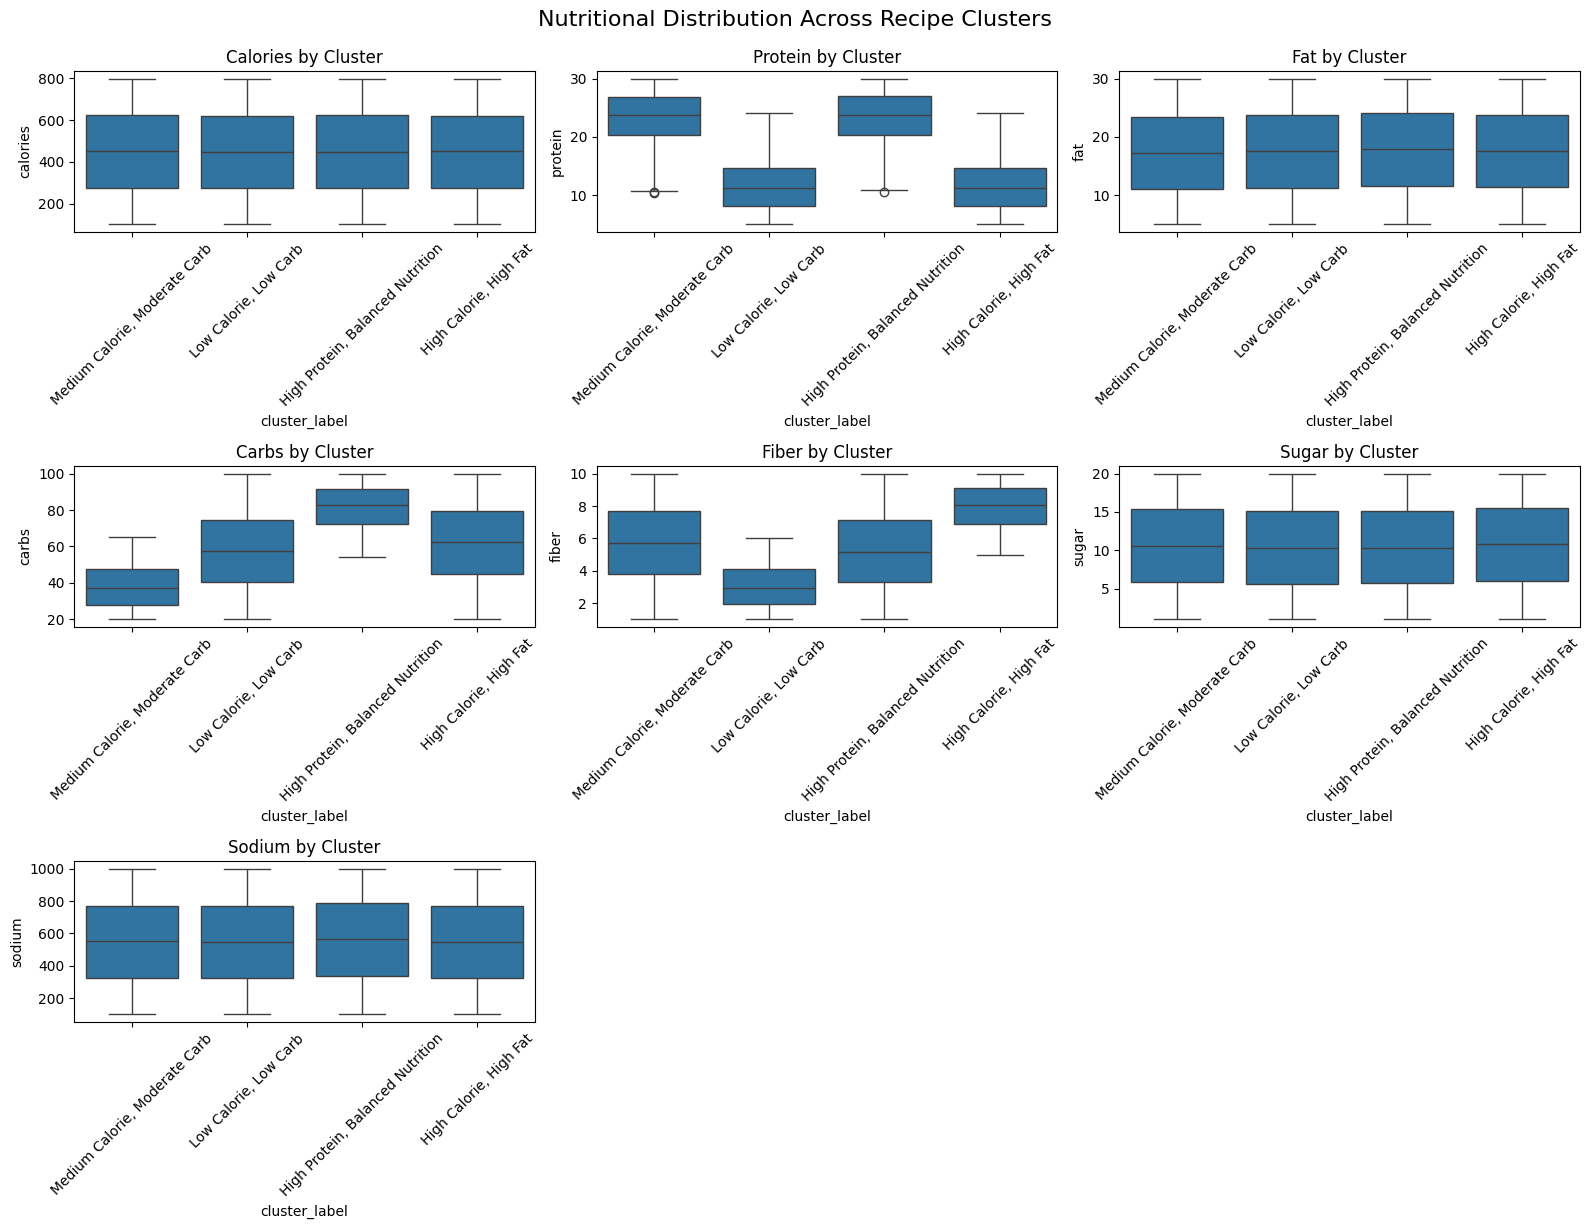

In [89]:

#Clustering Recipes Based on Nutritional Profiles Using K-Means
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load enriched recipe data
DATA_PATH = "data/enriched_recipes.csv"
df = pd.read_csv(DATA_PATH)

# Select nutritional features
nutrient_cols = ['calories', 'protein', 'fat', 'carbs', 'fiber', 'sugar', 'sodium']
X = df[nutrient_cols].fillna(0)

# Standardize the nutritional features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Get actual values from cluster centers
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=nutrient_cols
)

# Print all cluster summaries (optional)
print("\n=== Cluster Nutritional Summaries ===\n")
for idx, row in cluster_centers.iterrows():
    print(f"Cluster {idx}:\n{row}\n")

# Manually assign labels based on centroid values
custom_labels = {
    0: "Low Calorie, Low Carb",
    1: "High Calorie, High Fat",
    2: "High Protein, Balanced Nutrition",
    3: "Medium Calorie, Moderate Carb"
}

# Apply labels
df['cluster_label'] = df['cluster'].map(custom_labels)

# Save clustered data
df.to_csv("data/clustered_recipes.csv", index=False)

# Plot boxplots for each nutrient by cluster label
plt.figure(figsize=(16, 12))
for i, col in enumerate(nutrient_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x='cluster_label', y=col)
    plt.title(f'{col.capitalize()} by Cluster')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle("Nutritional Distribution Across Recipe Clusters", fontsize=16, y=1.02)
plt.savefig("results/cluster_nutrition_boxplots.png", bbox_inches="tight")
plt.show()

In [90]:
#Experiment 2
#Popularity-Based Recommendation by Time Period (Weekday vs Weekend).
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [91]:
#Files Needed
DATA_DIR = "data/"
interactions_path = os.path.join(DATA_DIR, "synthetic_interactions.csv")
recipes_path = os.path.join(DATA_DIR, "enriched_recipes.csv")

In [92]:
#Load and Process Data

# Load interaction data
interactions_df = pd.read_csv(interactions_path)
recipes_df = pd.read_csv(recipes_path)

# Convert timestamp to datetime
interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'])

# Add a column: weekday vs weekend
interactions_df['day_type'] = interactions_df['timestamp'].dt.weekday.apply(lambda x: 'weekend' if x >= 5 else 'weekday')

# Count recipe popularity by day_type
popularity_by_day = interactions_df.groupby(['day_type', 'recipe_id']).size().reset_index(name='count')

In [93]:
# Getting Top Recipes for Each Day Type

def get_top_recipes(day_type, top_n=5):
    top_ids = popularity_by_day[popularity_by_day['day_type'] == day_type] \
                .sort_values('count', ascending=False) \
                .head(top_n)['recipe_id'].tolist()
    
    top_recipes = recipes_df[recipes_df['id'].isin(top_ids)].copy()
    top_recipes['day_type'] = day_type
    return top_recipes

top_weekday = get_top_recipes('weekday', top_n=5)
top_weekend = get_top_recipes('weekend', top_n=5)

# Combine both
combined_top = pd.concat([top_weekday, top_weekend])

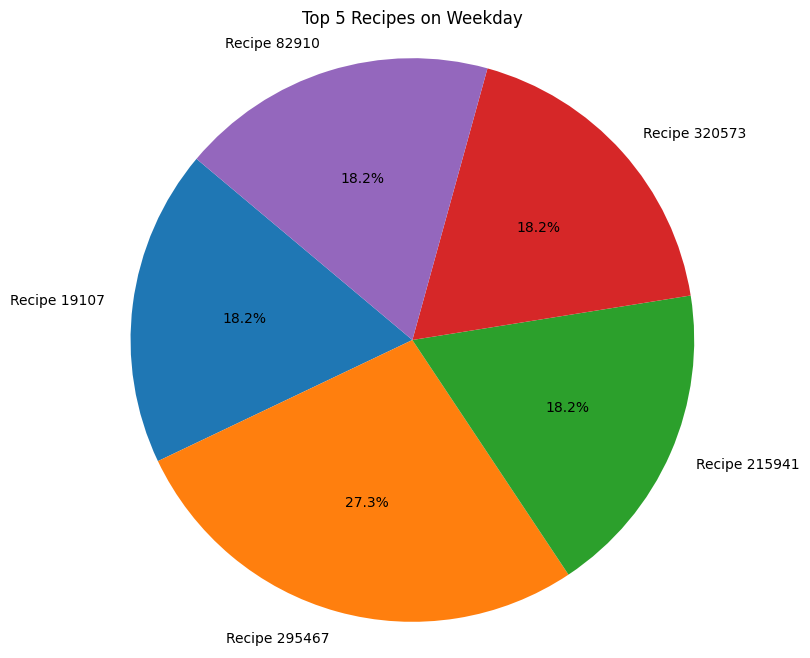

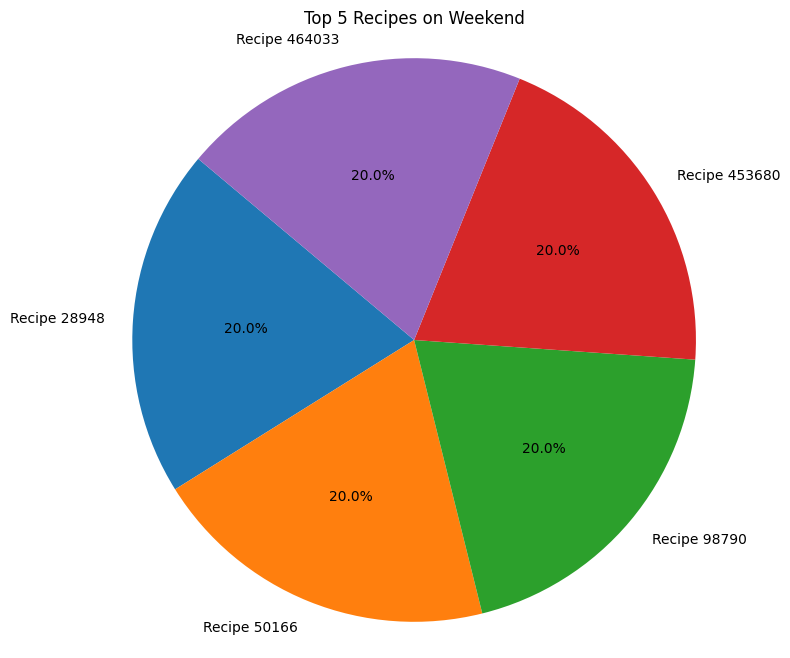

In [94]:
#Visualize Recipe Popularity

# Ensuring 'recipe_name' exists in recipes_df
if 'recipe_name' not in recipes_df.columns and 'name_tokens' in recipes_df.columns:
    import ast
    recipes_df['recipe_name'] = recipes_df['name_tokens'].apply(
        lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) else f"Recipe {x}"
    )

# Function to plot pie chart with recipe names
def plot_pie_chart(top_df, day_type):
    top_df = top_df.merge(
        popularity_by_day[(popularity_by_day['day_type'] == day_type)],
        left_on='id', right_on='recipe_id'
    )
    
    labels = top_df['recipe_name']
    sizes = top_df['count']
    
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Top 5 Recipes on {day_type.capitalize()}")
    plt.axis('equal')  # Equal aspect ratio
    
    # Save the plot
    filename = f"piechart_top_{day_type}_recipes_named.png"
    plot_path = os.path.join("results", filename)
    plt.savefig(plot_path)
    plt.show()


# Generate pie charts
plot_pie_chart(top_weekday, 'weekday')
plot_pie_chart(top_weekend, 'weekend')

In [95]:
# TEST CASE 1: Collaborative Filtering (SVD-based)
# Purpose: Recommend recipes to user based on collaborative filtering (user-item matrix).
# Method: Trains an SVD model with 50 latent factors.
# Input: user_id=1 (assumed to exist in synthetic_interactions.csv).
# Output: Top 5 recipe recommendations with predicted scores.
# Note: Works well when the user has rated multiple recipes. Relies on similarity of user-item interactions.

# Step 1: Initialize model
cf_model = CollaborativeFilteringModel()

# Step 2: Train the model using SVD (if not already trained)
cf_model.train(n_factors=50) 
# Step 3: Recommend recipes for a specific user (e.g., user_id = 1)
user_id = 1
top_n = 5
recommendations = cf_model.recommend(user_id=user_id, top_n=top_n)

# Step 4: Load enriched recipes to get recipe names
recipes_path = os.path.join("data", "enriched_recipes.csv")
import pandas as pd
recipes_df = pd.read_csv(recipes_path)

# Step 5: Print recommended recipes with names
print(f"\nTop {top_n} Collaborative Filtering Recommendations for User {user_id}:")
for rank, (recipe_id, score) in enumerate(recommendations, 1):
    recipe_name = recipes_df[recipes_df['id'] == recipe_id]['recipe_name'].values[0]
    print(f"{rank}. {recipe_name} (Predicted Score: {score:.3f})")


Training SVD model with 50 factors...
Loaded data for collaborative filtering
SVD model trained and saved to models/svd_model.pkl

Top 5 Collaborative Filtering Recommendations for User 1:
1. Recipe 278996 (Predicted Score: 2.701)
2. Recipe 348692 (Predicted Score: 2.701)
3. Recipe 37748 (Predicted Score: 2.161)
4. Recipe 52182 (Predicted Score: 2.161)
5. Recipe 74812 (Predicted Score: 2.161)


In [96]:
# TEST CASE 2: Content-Based Filtering (Nutrition Profile)

# Purpose:
# Recommend recipes based on nutritional similarity to the user's historical preferences.

# Method:
# - Uses dot product similarity (approximating cosine similarity) between:
#   (a) User profile vector (averaged nutritional features from liked recipes)
#   (b) Feature vectors of available recipes (nutrition attributes)
# - Applies optional filtering based on dietary preferences (e.g., low calorie).


# Initialize and load model
cb_model = ContentBasedFilteringModel()
cb_model.train()

# Test Case: Recommend recipes for user_id = 1
user_id = 1
top_n = 5

# Optional: Add dietary preference filter like low_calorie
recommendations = cb_model.recommend(user_id=user_id, top_n=top_n, dietary_preferences=['low_calorie'])

# Load enriched recipe data to show details
recipes_df = pd.read_csv("data/enriched_recipes.csv")

# Display the recommended recipes with nutritional similarity info
print(f"\nTop {top_n} Content-Based Recommendations for User {user_id} (Low Calorie):\n")
for rank, (recipe_id, similarity_score) in enumerate(recommendations, start=1):
    recipe = recipes_df[recipes_df['id'] == recipe_id].iloc[0]
    print(f"{rank}. {recipe['recipe_name']} (Similarity Score: {similarity_score:.4f})")
    print(f"   Calories: {recipe['calories']} kcal | Protein: {recipe['protein']}g | Fat: {recipe['fat']}g")


Training content-based filtering model...
Loaded data for content-based filtering
Content-based model ready

Top 5 Content-Based Recommendations for User 1 (Low Calorie):

1. Recipe 310434 (Similarity Score: 2.6630)
   Calories: 479 kcal | Protein: 5.47568464702592g | Fat: 5.970370724217159g
2. Recipe 432300 (Similarity Score: 2.5027)
   Calories: 482 kcal | Protein: 6.4875343547824045g | Fat: 5.57049483183797g
3. Recipe 121086 (Similarity Score: 2.4591)
   Calories: 371 kcal | Protein: 7.88929037750599g | Fat: 6.096854144679635g
4. Recipe 45755 (Similarity Score: 2.4132)
   Calories: 382 kcal | Protein: 6.058804090297699g | Fat: 6.430790510305208g
5. Recipe 393809 (Similarity Score: 2.3882)
   Calories: 282 kcal | Protein: 5.101479265424098g | Fat: 5.174508743278867g


In [97]:
# TEST CASE 3: Hybrid Recommendation (CF + CB)
# Purpose: Combine strengths of Collaborative Filtering (CF) and Content-Based Filtering (CB)
#          to provide more robust and personalized recipe suggestions.
# Method: Merges normalized scores from both CF and CB using a weighted average controlled by alpha.
# Input: user_id = 3 (example user from interaction history),
#        dietary_preference = ['low_calorie'],
#        alpha = 0.6 (60% CF influence, 40% CB influence),
#        top_n = 3 (return top 3 recommendations).
# Output: 3 hybrid personalized recipes with enriched nutritional and ingredient details.


# Step 1: Initialize the hybrid recommender system
hybrid = HybridRecommendationSystem()

# Step 2: Train both collaborative and content-based models
hybrid.train_models()

# Step 3: Choose a valid user_id that exists in interactions.csv
test_user_id = 1  # Use a valid user_id from your dataset

# Step 4: Generate hybrid recommendations
alpha = 0.7  # Weight more toward CF (can test with 0.5 or 0.3 to shift balance)
top_n = 5
dietary_filter = ['low_calorie']

recommendations = hybrid.recommend(
    user_id=test_user_id,
    top_n=top_n,
    alpha=alpha,
    dietary_preferences=dietary_filter
)

# Step 5: Print the results
print(f"\nHybrid Recommendations for User {test_user_id} (alpha={alpha}):")
for i, (recipe_id, score) in enumerate(recommendations, start=1):
    details = hybrid.get_recipe_details(recipe_id)
    print(f"{i}. {details['name']} (Score: {score:.3f})")
    print(f"   Calories: {details['nutrition']['calories']} kcal")


Training hybrid recommendation system...
Training SVD model with 50 factors...
Loaded data for collaborative filtering
SVD model trained and saved to models/svd_model.pkl
Training content-based filtering model...
Loaded data for content-based filtering
Content-based model ready
Hybrid recommendation system ready
Generating recommendations for user 1...

Hybrid Recommendations for User 1 (alpha=0.7):
1. Recipe 278996 (Score: 0.700)
   Calories: 594 kcal
2. Recipe 348692 (Score: 0.700)
   Calories: 534 kcal
3. Recipe 52182 (Score: 0.350)
   Calories: 778 kcal
4. Recipe 78111 (Score: 0.350)
   Calories: 553 kcal
5. Recipe 388386 (Score: 0.350)
   Calories: 379 kcal


In [98]:
#TEST CASE 4: Ingredient Substitution
# Purpose: Suggest alternatives for a specific ingredient under dietary restrictions.
# Method: Uses predefined or similarity-based ingredient substitution model.
# Input: ingredient = "milk", restriction = "vegan".
# Output: Top 3 substitutes excluding animal-based items.
subs_model = IngredientSubstitutionModel()
subs_model.find_substitutes('milk', top_n=3, dietary_restrictions=['vegan'])

Loaded ingredient similarity data
Ingredient 'milk' not found in database
Generating dummy substitutes for 'milk'


[('almond milk', 0.9), ('soy milk', 0.8), ('oat milk', 0.7)]

In [99]:
# TEST CASE 5: Clustering Based on Nutrition (K-Means)
# Purpose: Understand nutritional profiles of recipes via clustering.
# Method: K-Means applied on scaled calorie, protein, fat, etc.
# Input: Preprocessed clustered dataset (clustered_recipes.csv).
# Output: Sample recipes from 'High Protein, Balanced Nutrition' cluster.
df = pd.read_csv("data/clustered_recipes.csv")
df[df['cluster_label'] == 'High Protein, Balanced Nutrition'][['recipe_name', 'protein']].head()

,recipe_name,protein
2,Recipe 312329,28.264455
4,Recipe 76272,17.987540
9,Recipe 303460,29.931078
10,Recipe 408927,21.696586
15,Recipe 154406,26.132685


In [100]:
# TEST CASE 6: Popularity by Weekday vs Weekend
# Purpose: Analyze user behavior and find trending recipes by day type.
# Method: Uses timestamp to classify interactions into weekday/weekend.
# Input: 'weekday' and 'weekend' as day_type.
# Output: Top 3 most popular recipes for each.
weekday_recipes = get_top_recipes('weekday', top_n=3)[['recipe_name', 'day_type']]
print(weekday_recipes)

          recipe_name day_type
4286     Recipe 19107  weekday
110990  Recipe 295467  weekday
176559  Recipe 320573  weekday


In [101]:
weekend_recipes = get_top_recipes('weekend', top_n=3)[['recipe_name', 'day_type']]
print(weekend_recipes)

        recipe_name day_type
34018  Recipe 28948  weekend
41347  Recipe 50166  weekend
45221  Recipe 98790  weekend
